In [ ]:
# instead of conditioning on the time we use all the times as the output

# it's a brute force 'not empirical' interpolation

# one could use multi-banding to reducing the output dimension

In [1]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':16})

import numpy as np

import sklearn.preprocessing
import sklearn.model_selection

import pycbc.types
import pycbc.waveform
import pycbc.pnutils
import pycbc.conversions

import lal
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [2]:
import tensorflow as tf
import wispy.callbacks
import tensorflow_addons as tfa

In [3]:
from tf_fourier_features import FourierFeatureProjection

In [4]:
def StoM(S, Mtot):
    """StoM(S, Mtot)
    """
    return S / (lal.MTSUN_SI*Mtot)

def MtoS(M, Mtot):
    """MtoS(Hz, Mtot)
    """
    return M * (lal.MTSUN_SI*Mtot)

def td_amp_scale(mtot, distance):
    """
    mtot in solar masses
    distance in m
    M*G/c^2 * M_sun / dist
    """
    return mtot * lal.MRSUN_SI / distance

In [1223]:
def generate_waveform(new_times_M, mass_ratio=1, total_mass=100, chi=0, approximant="SEOBNRv4_opt", distance_mpc=1):
    
    mass1=pycbc.conversions.mass1_from_mtotal_q(total_mass, mass_ratio)
    mass2=pycbc.conversions.mass2_from_mtotal_q(total_mass, mass_ratio)

    # mass1=pycbc.conversions.mass1_from_mtotal_q(100, 4)
    # mass2=pycbc.conversions.mass2_from_mtotal_q(100, 4)

    # can scale amp by eta
    # eta = pycbc.conversions.eta_from_mass1_mass2(mass1, mass2)

    params = dict(
        # spin1x=mass_ratio,
        mass1=mass1,
        mass2=mass2,
        # spin1z=chi,
        # spin2z=chi,
        spin1x=chi,
        approximant=approximant,
        f_lower=8,
        delta_t=1/4096,
        distance=distance_mpc
        )
    hp, hc = pycbc.waveform.get_td_waveform(**params)
    delta_t = hp.delta_t

    amp = pycbc.waveform.utils.amplitude_from_polarizations(hp, hc).numpy()
    phase = pycbc.waveform.utils.phase_from_polarizations(hp, hc, remove_start_phase=True).numpy()

    times_M = StoM(hp.sample_times.numpy(), total_mass)

    new_amp = IUS(times_M, amp)(new_times_M)

    distance_m = 1e6*distance_mpc*lal.PC_SI
    new_amp /= td_amp_scale(total_mass, distance_m)

    new_phase = IUS(times_M, phase)(new_times_M)
    new_phase += -new_phase[0]
    
    h = new_amp * np.exp(-1.j * new_phase)
    hp = np.real(h)
    # hc = np.imag(h)

    # return hp
    return new_amp
    # return new_phase

In [1224]:
mass_ratio = 4
# mass_ratio = 0.95
chi=0.99
# chi=0.
total_mass = 100
# approximant = "SEOBNRv4_opt"
approximant = "SEOBNRv4P"
# approximant = "SEOBNRv3_opt"
distance_mpc = 1


# uniform spacing throughout
# t1 = -1000
t1 = -500
# t1 = -200
# t1 = -2000
# t1 = -5000
# t2 = 100
t2 = 70
# dt = 0.5
# dt = 1
# dt = 0.25
dt = 5
new_times_M = np.arange(t1, t2, dt)

# implement higher sample rate for merger

# # # region 1 inspiral
# # r1_t1 = -500
# r1_t1 = -2000
# r1_t2 = -200
# r1_dt = 4
# # r1_dt = 8
# r1_new_times_M = np.arange(r1_t1, r1_t2, r1_dt)


# # region 2 merger-ringdown
# r2_t1 = r1_t2
# r2_t2 = 70
# # r2_dt = 0.25
# r2_dt = 0.75
# r2_new_times_M = np.arange(r2_t1, r2_t2, r2_dt)

# new_times_M = np.concatenate((r1_new_times_M, r2_new_times_M))



In [1225]:
new_times_M.shape


(114,)

In [1226]:
hp = generate_waveform(new_times_M=new_times_M, mass_ratio=mass_ratio, total_mass=total_mass, chi=chi, approximant=approximant, distance_mpc=distance_mpc)

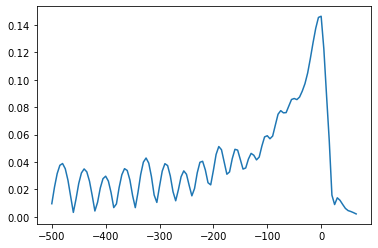

In [1227]:
plt.plot(new_times_M, hp)

In [1228]:
# qs = np.linspace(3, 5, 2)
# qs = np.linspace(1,3,400)
qs = np.linspace(3,5,400)
chis = np.array([0.6])
# qs = np.array([1.])
# qs = np.arange(1, 1.2, 0.01)
# qs = np.arange(2, 3, 0.05)
# chis = np.linspace(-0.99, 0.99, 40)
# chis = np.linspace(0.8, 0.99, 40)
# chis = np.linspace(0.8, 0.99, 2)
# chis = np.array([0.])
# chis = np.linspace(0., 0.5, 30)
# chis = np.linspace(0., 0.1, 5)
# chis = np.arange(0., 0.5, 0.01)
# chis = np.arange(-0.99, 0.99, 0.45)
# chis = np.arange(0.8, 0.9, 0.01)
# chis = np.arange(0.8, 0.99, 0.005)

# qs = np.linspace(1, 3, 5)
# chis = np.linspace(-0.99, 0.99, 5)


# chis = np.linspace(0.8, 0.99, 30)
# chis_1 = np.linspace(-0.99, 0.5, 10)
# chis_2 = np.linspace(0.5, 0.99, 10)
# chis = np.concatenate((chis_1, chis_2))

XX, YY = np.meshgrid(qs, chis)
XX = XX.ravel()
YY = YY.ravel()

In [1229]:
test_chi_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-0.5, 0.5))
test_chi_scaled = test_chi_scaler.fit_transform(chis[:,np.newaxis])[:,0]

In [1230]:
plt.scatter(XX, YY)

In [1231]:
num_samples = len(XX)

In [1232]:
num_samples

400

In [1233]:
%%time
hps = []
for i in range(num_samples):
    mass_ratio = XX[i]
    chi = YY[i]
    hp = generate_waveform(new_times_M=new_times_M, mass_ratio=mass_ratio, chi=chi, total_mass=total_mass, approximant=approximant, distance_mpc=distance_mpc)
    hps.append(hp)
hps = np.array(hps)

CPU times: user 7min 28s, sys: 3.47 s, total: 7min 31s
Wall time: 7min 31s


In [1234]:
hps.shape

(400, 114)

In [1235]:
theta = np.column_stack((XX, YY))

In [1236]:
theta.shape

(400, 2)

In [1237]:
theta_idxs = np.arange(len(theta))


# if you want the training set and validation set to have
# different mass-ratios then uncomment
theta_training_idxs = theta_idxs[::2]


# the next lines are a bit confusing
# but 
# if you do q_idxs[1::2] then the last data point it outside the training set
# so for the training idxs I also add in the last data point
# that would have been totally excluded
theta_training_idxs = np.concatenate((theta_training_idxs, [theta_idxs[-1]]))
theta_validation_idxs = theta_idxs[1:-1:2] 

# use this if you want the train and val sets to have the same mass-ratios
# but they will be using alternating time samples
# theta_training_idxs = theta_idxs
# theta_validation_idxs = theta_idxs

In [1238]:
theta_training_idxs

array([  0,   2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,
        26,  28,  30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,
        52,  54,  56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,
        78,  80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 100, 102,
       104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128,
       130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154,
       156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180,
       182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206,
       208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232,
       234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258,
       260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284,
       286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310,
       312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336,
       338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 36

In [1239]:
theta_validation_idxs

array([  1,   3,   5,   7,   9,  11,  13,  15,  17,  19,  21,  23,  25,
        27,  29,  31,  33,  35,  37,  39,  41,  43,  45,  47,  49,  51,
        53,  55,  57,  59,  61,  63,  65,  67,  69,  71,  73,  75,  77,
        79,  81,  83,  85,  87,  89,  91,  93,  95,  97,  99, 101, 103,
       105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127, 129,
       131, 133, 135, 137, 139, 141, 143, 145, 147, 149, 151, 153, 155,
       157, 159, 161, 163, 165, 167, 169, 171, 173, 175, 177, 179, 181,
       183, 185, 187, 189, 191, 193, 195, 197, 199, 201, 203, 205, 207,
       209, 211, 213, 215, 217, 219, 221, 223, 225, 227, 229, 231, 233,
       235, 237, 239, 241, 243, 245, 247, 249, 251, 253, 255, 257, 259,
       261, 263, 265, 267, 269, 271, 273, 275, 277, 279, 281, 283, 285,
       287, 289, 291, 293, 295, 297, 299, 301, 303, 305, 307, 309, 311,
       313, 315, 317, 319, 321, 323, 325, 327, 329, 331, 333, 335, 337,
       339, 341, 343, 345, 347, 349, 351, 353, 355, 357, 359, 36

In [1240]:
len(theta_idxs)

400

In [1241]:

len(theta_training_idxs)


201

In [1242]:

len(theta_validation_idxs)

199

In [1243]:
theta_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-0.5, 0.5))
theta_scaled = theta_scaler.fit_transform(theta)
# theta_scaled = theta_scaler.fit_transform(theta_1_scaled)

In [1244]:
hps_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-0.5, 0.5))

hps_shape = hps.shape
hps_scaled = hps_scaler.fit_transform(hps.reshape(-1, 1)).reshape(hps_shape)

In [1245]:
X_training = theta_scaled[theta_training_idxs]

In [1246]:
X_validation = theta_scaled[theta_validation_idxs]

In [1247]:
X_training.shape

(201, 2)

In [1248]:
X_validation.shape

(199, 2)

In [1249]:
hps.shape

(400, 114)

In [1250]:
# y_training = hps[np.ix_(theta_training_idxs, t_training_idxs)]
# y_training = y_training.reshape(-1, 1)
# y_validation = hps[np.ix_(theta_validation_idxs, t_validation_idxs)]
# y_validation = y_validation.reshape(-1, 1)


# https://stackoverflow.com/questions/35607818/index-a-2d-numpy-array-with-2-lists-of-indices
y_training = hps_scaled[theta_training_idxs]
# y_training = y_training.reshape(-1, 1)
y_validation = hps_scaled[theta_validation_idxs]
# y_validation = y_validation.reshape(-1, 1)

In [1251]:
y_training.shape

(201, 114)

In [1252]:
y_validation.shape

(199, 114)

In [1253]:
plt.figure()
plt.plot(new_times_M, y_training[0])

In [1254]:
def gaussian_activation(x, c=0, sigma=1):
    return tf.math.exp(-(x-c)**2 / (2*sigma**2))    

In [1255]:
def run_simple_model(X_train, y_train, input_shape, output_shape, epochs=1001, threshold=1e-7, batch_size=32, validation_data=None, learning_rate=1e-3, verbose=0, model_version="1", validation_batch_size=None):
    activation = 'relu'
    # activation = gaussian_activation
    # activation = 'softplus'
    units = 256
    # units = 64
    # units = 512
    # units = 1024
    n_layers = 3
    # n_layers = 6
    # gaussian_projection = 256
    gaussian_projection = 16
    # gaussian_scale = 64/4/8
    
    # gaussian_scale = 64
    # gaussian_scale = 32
    # gaussian_scale = 8
    # gaussian_scale = 4
    gaussian_scale = 2
    # gaussian_scale = 1
    # gaussian_scale = 0.3
    # gaussian_scale = 0.1


    inputs = tf.keras.Input(shape=(input_shape,))
    x = FourierFeatureProjection(gaussian_projection = gaussian_projection, gaussian_scale = gaussian_scale)(inputs)
    # x = tf.keras.layers.Dense(units, activation)(inputs)
    
    for i in range(n_layers):
        x = tf.keras.layers.Dense(units, activation)(x)
    outputs = tf.keras.layers.Dense(output_shape)(x)
    
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    callbacks = [
        # tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
        wispy.callbacks.ThresholdCallback(threshold),
        # tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=200, factor=0.9, monitor='val_loss'),
        # tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=200, factor=0.6, monitor='val_loss'),
        tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=500, factor=0.6, monitor='val_loss'),        
        # tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=50, factor=0.5, monitor='loss'),
        # tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=300),
    ]
    
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate))
    
    print(model.summary())

    history = model.fit(x=X_train, y=y_train, epochs=epochs, verbose=verbose, batch_size=batch_size, callbacks=callbacks, validation_data=validation_data, validation_batch_size=validation_batch_size)
    
    return history, model

In [1256]:
input_shape = X_training.shape[1]
output_shape = y_training.shape[1]

In [1257]:
X_training.shape

(201, 2)

In [1258]:
y_training.shape

(201, 114)

In [1259]:
len(X_training)//5

40

In [1260]:
# epochs=200
epochs=2000
batch_size = 32
# batch_size = 128
# batch_size = 512
# batch_size = 1024
# batch_size = 2048
# batch_size = 4096
# batch_size = 8192
# batch_size = 130560
# batch_size = len(X_training)//5
# batch_size = len(X_training)//20

# validation_batch_size=8192
validation_batch_size=None
print(batch_size)

# learning_rate = 1e-2
learning_rate = 1e-3
# learning_rate = 1e-4
print(learning_rate)

32
0.001


In [1261]:
%%time
history, model = run_simple_model(
    X_training,
    y_training,
    input_shape=input_shape,
    output_shape=output_shape,
    epochs=epochs,
    batch_size=batch_size,
    # validation_data=(X_validation, y_validation),
    validation_data=(X_validation, y_validation),
    # validation_data=None,
    learning_rate=learning_rate,
    # threshold=4e-6,
    threshold=4e-8,
    verbose=1,
    validation_batch_size=validation_batch_size,
    # threshold=3e-6
    )

Model: "model_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_41 (InputLayer)       [(None, 2)]               0         
                                                                 
 fourier_feature_projection_  (None, 32)               32        
 37 (FourierFeatureProjectio                                     
 n)                                                              
                                                                 
 dense_163 (Dense)           (None, 256)               8448      
                                                                 
 dense_164 (Dense)           (None, 256)               65792     
                                                                 
 dense_165 (Dense)           (None, 256)               65792     
                                                                 
 dense_166 (Dense)           (None, 114)               292

2022-06-21 20:56:02.669084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 1s 39ms/step - loss: 0.0299 - val_loss: 0.0101 - lr: 0.0010
Epoch 2/2000
7/7 [==============================] - 0s 13ms/step - loss: 0.0069 - val_loss: 0.0041 - lr: 0.0010
Epoch 3/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0043

2022-06-21 20:56:02.928215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 13ms/step - loss: 0.0036 - val_loss: 0.0028 - lr: 0.0010
Epoch 4/2000
7/7 [==============================] - 0s 14ms/step - loss: 0.0025 - val_loss: 0.0021 - lr: 0.0010
Epoch 5/2000
7/7 [==============================] - 0s 12ms/step - loss: 0.0020 - val_loss: 0.0017 - lr: 0.0010
Epoch 6/2000
7/7 [==============================] - 0s 12ms/step - loss: 0.0017 - val_loss: 0.0016 - lr: 0.0010
Epoch 7/2000
7/7 [==============================] - 0s 13ms/step - loss: 0.0016 - val_loss: 0.0015 - lr: 0.0010
Epoch 8/2000
7/7 [==============================] - 0s 13ms/step - loss: 0.0015 - val_loss: 0.0014 - lr: 0.0010
Epoch 9/2000
7/7 [==============================] - 0s 13ms/step - loss: 0.0014 - val_loss: 0.0014 - lr: 0.0010
Epoch 10/2000
7/7 [==============================] - 0s 13ms/step - loss: 0.0014 - val_loss: 0.0013 - lr: 0.0010
Epoch 11/2000
7/7 [==============================] - 0s 12ms/step - loss: 0.0014 - val_loss: 0.0013 - lr: 0.0010
Epo

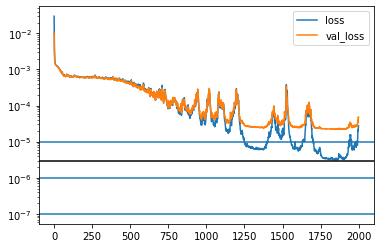

In [1262]:
plt.figure()
plt.plot(history.history["loss"], label='loss')
plt.plot(history.history["val_loss"], label='val_loss')
plt.legend()
plt.axhline(1e-5)
plt.axhline(1e-6)
plt.axhline(3e-6, c='k')
plt.axhline(1e-7)
plt.yscale("log")

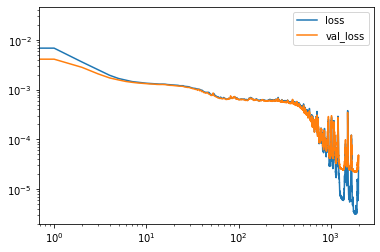

In [1263]:
plt.figure()
plt.plot(history.history["loss"], label='loss')
plt.plot(history.history["val_loss"], label='val_loss')
plt.legend()
plt.yscale("log")
plt.xscale("log")

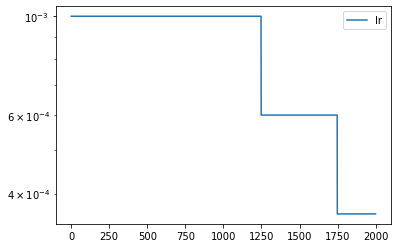

In [1264]:
try:
    plt.figure()
    plt.plot(history.history["lr"], label='lr')
    plt.legend()
    plt.yscale("log")
    # plt.xscale("log")
except:
    pass

In [1265]:
model.summary()

Model: "model_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_41 (InputLayer)       [(None, 2)]               0         
                                                                 
 fourier_feature_projection_  (None, 32)               32        
 37 (FourierFeatureProjectio                                     
 n)                                                              
                                                                 
 dense_163 (Dense)           (None, 256)               8448      
                                                                 
 dense_164 (Dense)           (None, 256)               65792     
                                                                 
 dense_165 (Dense)           (None, 256)               65792     
                                                                 
 dense_166 (Dense)           (None, 114)               292

In [1266]:
test_input = theta_scaled[theta_training_idxs[-1]]
test_yhat = model.predict(test_input[np.newaxis,:], verbose=0)

2022-06-21 20:58:53.353815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [1267]:
test_yhat.shape

(1, 114)

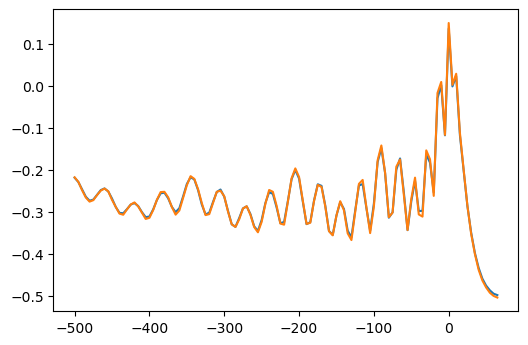

In [1268]:
plt.figure(dpi=100)
plt.plot(new_times_M, y_training[-1])
plt.plot(new_times_M, test_yhat[0])
# plt.xlim(-100, 100)

In [1269]:
plt.figure(dpi=100)
plt.plot(new_times_M, y_training[-1])
plt.plot(new_times_M, test_yhat[0])
plt.xlim(-100, 100)

(-100.0, 100.0)

In [1270]:
plt.figure(dpi=100)
plt.plot(new_times_M, y_training[0]-test_yhat[0])
# plt.xlim(-100, 100)

In [1271]:
test_input = theta_scaled[theta_validation_idxs[-1]]
test_yhat = model.predict(test_input[np.newaxis,:], verbose=0)

In [1272]:
%%timeit
model.predict(test_input[np.newaxis,:], verbose=0)

21.1 ms ± 366 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [1273]:
test_yhat.shape

(1, 114)

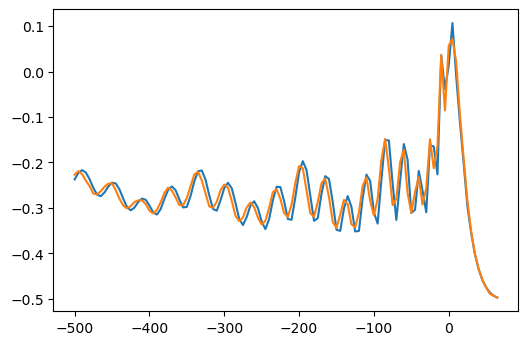

In [1274]:
plt.figure(dpi=100)
plt.plot(new_times_M, y_validation[-1])
plt.plot(new_times_M, test_yhat[0])
# plt.xlim(-100, 100)

(-100.0, 100.0)

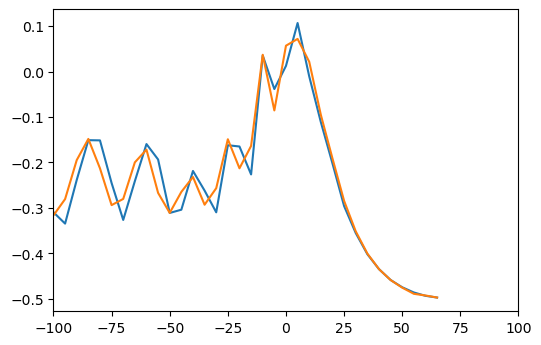

In [1275]:
plt.figure(dpi=100)
plt.plot(new_times_M, y_validation[-1])
plt.plot(new_times_M, test_yhat[0])
plt.xlim(-100, 100)

In [1276]:
plt.figure(dpi=100)
plt.plot(new_times_M, y_validation[-1]-test_yhat[0])
# plt.xlim(-100, 100)